### Executive Summary

Social netoworks and media platforms are challenged with effectively facilitating open conversations. This results in many such communities preventing users from expressing their opinions, giving feedback etc. on their platform. On the other hand, in open forums the possibility of being verbally abused and harrassed by strangers online is not a great motivator for people to engage and learn from one another's perspectives.

#### CAUTION!!! You may find content of this dataset *offensive*!

### Goal

Develop a set of ML models that can accurately classify and flag/remove comments that are toxic, threating, insulting, hateful and/or obscene in nature. Thereby, enabling users to engage more openly and social media platforms to better facitilate online conversations. 

### Metrics

The dataset has six (6) classes so the goal is to evaluate accuracy based on class-wise (avg) ROC AUC across all targets.

### Findings

The dataset is highly unbalanced across all target classes.

### Risks/limitations/assumptions affect these findings

Given that all (6) classes in the dataset are highly unbalanced, creating models that will generalize well will be challenging.

## Import neccessary data processing and visualization libraries

In [5]:
# Data processing and modeling
import re
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from scipy.sparse import hstack

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

# conda install -c conda-forge spacy
# python -m spacy download en
from spacy import load
nlp = load('en') # load model with shortcut link "en"

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

#### Load and examine data

##### *NOTE*: For the sake of faster execution times, limit the number of rows retrieved

In [8]:
# rows_limit=1000
# data = pd.read_csv("train.csv",nrows=rows_limit)
# test = pd.read_csv('test.csv',nrows=rows_limit)

# NOTE: Uncomment the following when not in "test" mode; This will take some code snippets to take longer than you'd want to wait!
data = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [9]:
data.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


##### **Observations**: 
* Note that a given comment may be classified as one or more classes -- ***toxic, severe_toxic, obscene, threat, insult and/or identity_hate***
* Will need to create six (6) models -- one per target

## Statistical Analysis

#### Check to see if there are any missing values

In [10]:
data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

#### Examine baseline distribution across all targets

In [11]:
targets = ['toxic', 'insult', 'obscene', 'identity_hate', 'severe_toxic', 'threat']

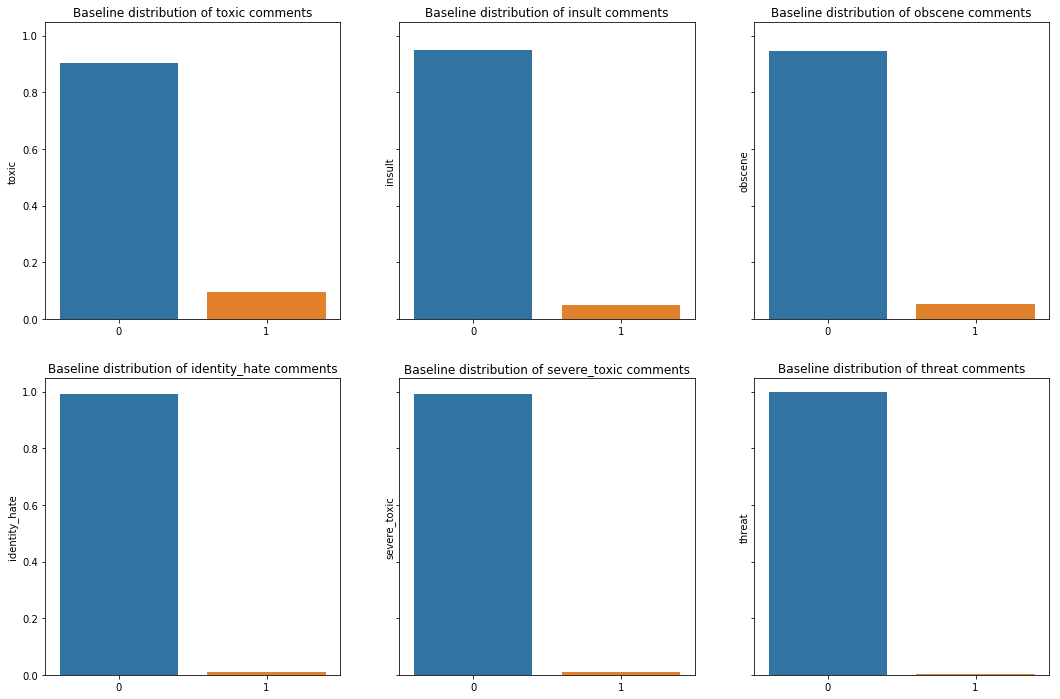

In [12]:
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = sns.mpl.pyplot.subplots(2, 3, figsize=(18,12), sharey="all")
axes = [ax1,ax2,ax3,ax4,ax5,ax6]

for i,target in enumerate(targets):
    ax = axes[i]
    ax.set_title("Baseline distribution of "+target+" comments")
    sns.barplot(x=data[target].value_counts().index, y=data[target].value_counts(normalize=True), ax=ax);

##### **Observation**: Note that all targets are heavily unbalanced so oversampling-undersampling will be beneficial during modeling process.

#### Visualize comments length distribution

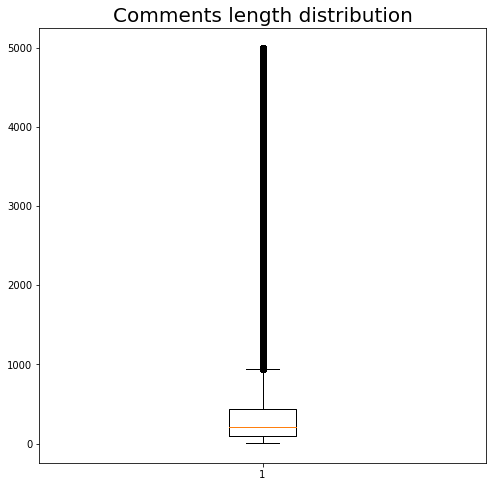

In [13]:
comments_lengths = [len(comment.strip()) for comment in data["comment_text"]]
sns.mpl.pyplot.figure(figsize=(8, 8))
sns.mpl.pyplot.title("Comments length distribution", fontsize=20)
sns.mpl.pyplot.boxplot(comments_lengths)
plt.show();

In [14]:
print("Avg words per comment: {0:.2f}".format(np.mean(comments_lengths)))

Avg words per comment: 394.07


#### Examine correlations between targets

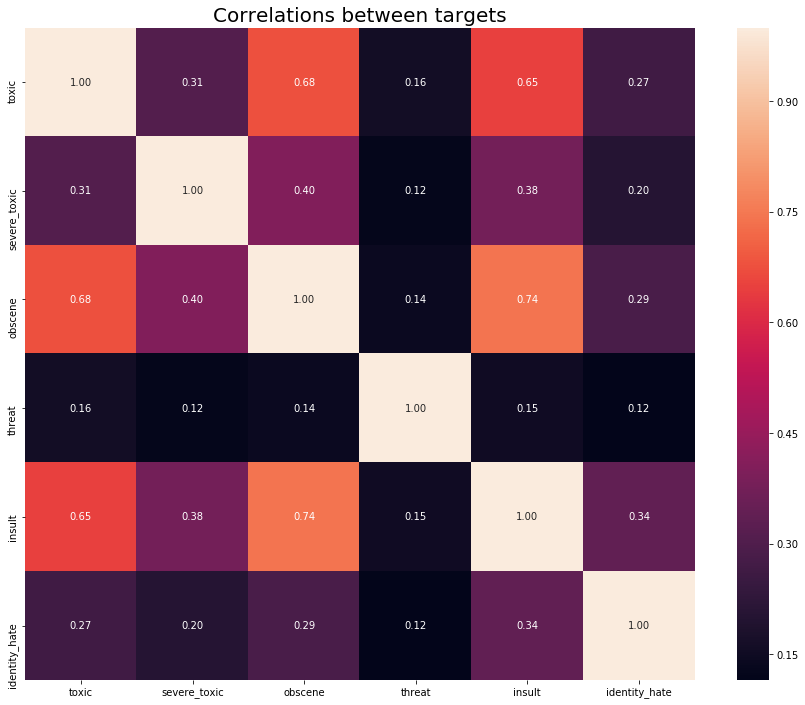

In [15]:
features = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
sns.mpl.pyplot.figure(figsize=(15, 12))
sns.mpl.pyplot.title("Correlations between targets", fontsize=20)
sns.heatmap(data[features].corr(), annot=True, fmt=".2f");

##### **Observation**: Note that we might be able to use correlated targets as features for predicting other targets.

#### Total counts for each target  

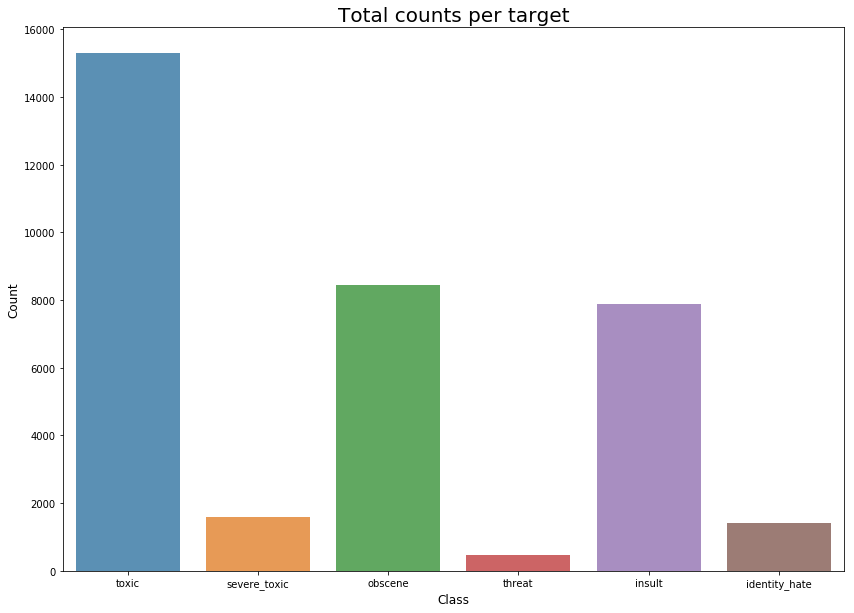

In [16]:
class_counts=data.iloc[:,2:].sum()
# print(class_counts)
sns.mpl.pyplot.figure(figsize=(14, 10))
sns.mpl.pyplot.title("Total counts per target", fontsize=20)
sns.mpl.pyplot.ylabel('Count', fontsize=12)
sns.mpl.pyplot.xlabel('Class', fontsize=12)
sns.barplot(class_counts.index, class_counts.values, alpha=0.8);

#### Total labels per comment 

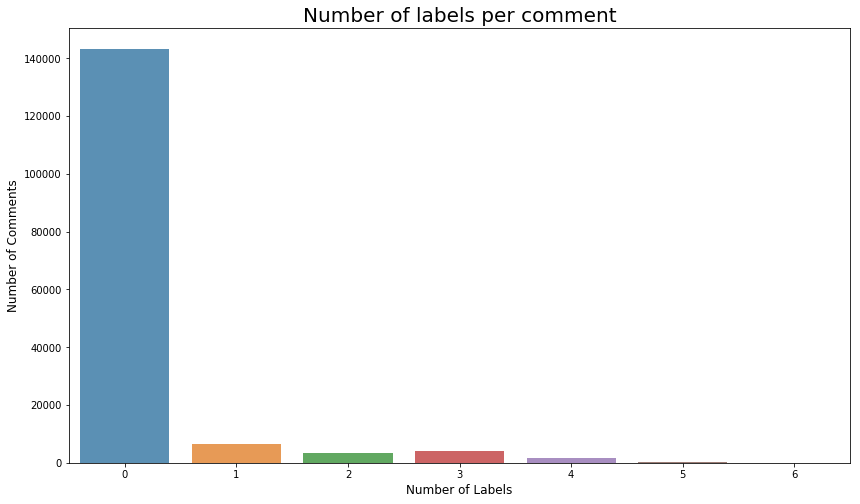

In [17]:
multi_tags=data.sum(axis=1).value_counts()
# print(multi_tags)
sns.mpl.pyplot.figure(figsize=(14, 8))
sns.mpl.pyplot.title("Number of labels per comment", fontsize=20)
sns.mpl.pyplot.ylabel('Number of Comments', fontsize=12)
sns.mpl.pyplot.xlabel('Number of Labels', fontsize=12)
sns.barplot(multi_tags.index, multi_tags.values, alpha=0.8);

#### Top 20 word frequencies 

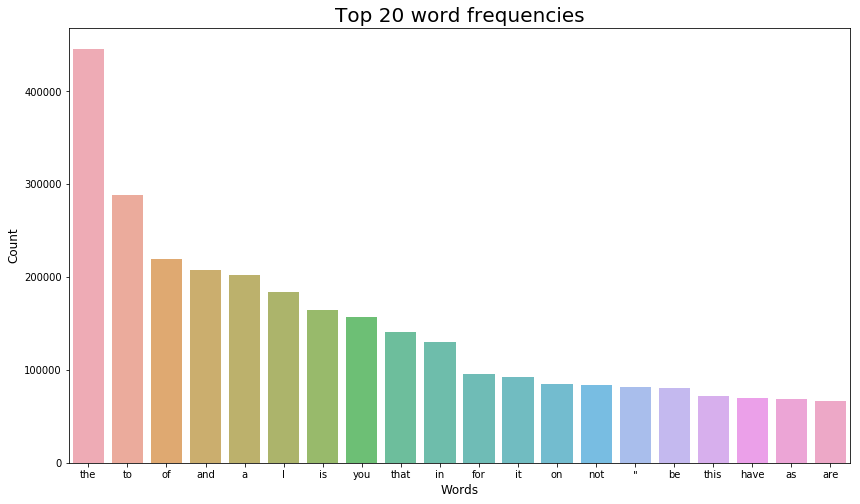

In [18]:
all_words = data['comment_text'].str.split(expand=True).unstack().value_counts().sort_values(ascending=False).head(20)
sns.mpl.pyplot.figure(figsize=(14, 8))
sns.mpl.pyplot.title("Top 20 word frequencies", fontsize=20)
sns.mpl.pyplot.ylabel('Count', fontsize=12)
sns.mpl.pyplot.xlabel('Words', fontsize=12)
sns.barplot(all_words.index, all_words.values, alpha=0.8);

#### Function that accepts ***text*** and ***title*** as arguments and displays word cloud based on those values

In [19]:
def word_cloud(text,title):
    wc= WordCloud(background_color="black",max_words=2000,stopwords=stop) #exclude stop words
    wc.generate(" ".join(text))   
    sns.mpl.pyplot.figure(figsize=(15, 15))
    sns.mpl.pyplot.title(title, fontsize=20)
    sns.mpl.pyplot.axis("off")
    sns.mpl.pyplot.imshow(wc.recolor(colormap='viridis', random_state=42), alpha=0.98)
    sns.mpl.pyplot.show()

#### Visualize words frequently appearing in comments

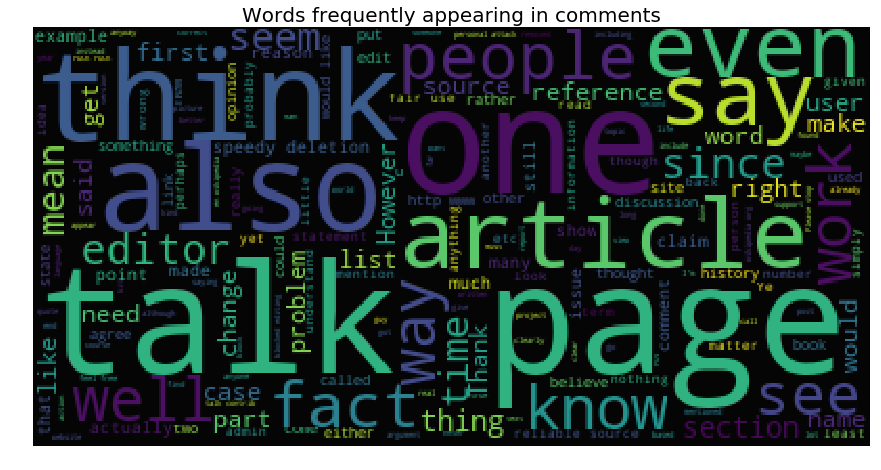

In [20]:
text = data['comment_text'].values
word_cloud(text,"Words frequently appearing in comments")

### CAUTION!!! -- you may find the following content *offensive*!

#### Visualize words frequently appearing in ***toxic*** comments

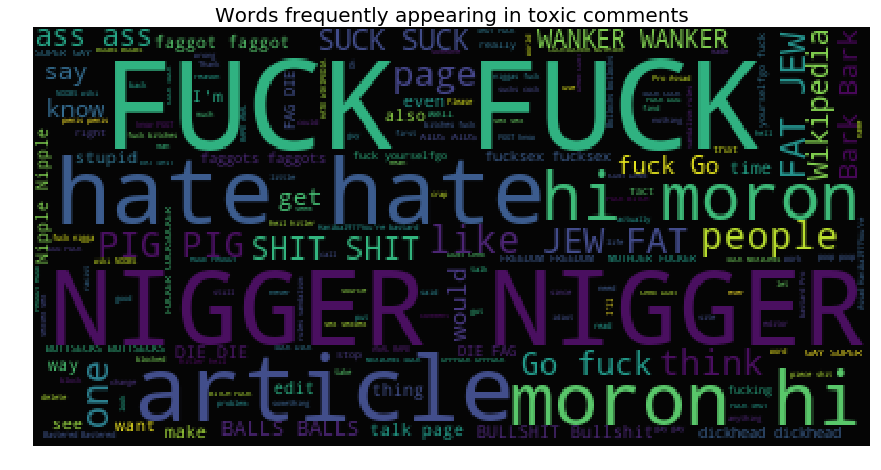

In [21]:
text = data[data["toxic"]==1]['comment_text'].values
word_cloud(text,"Words frequently appearing in toxic comments")

### CAUTION!!! -- you may find the following content *offensive*!

#### Visualize words frequently appearing in ***severely toxic*** comments

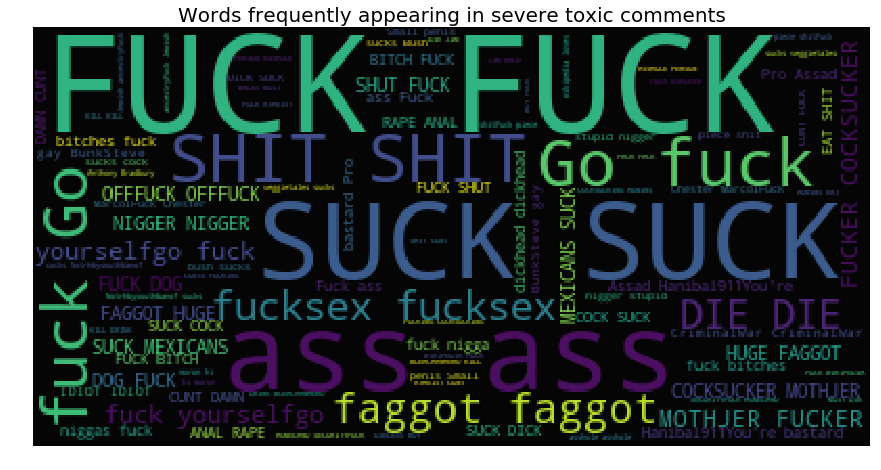

In [22]:
text = data[data["severe_toxic"]==1]['comment_text'].values
word_cloud(text,"Words frequently appearing in severe toxic comments")

### CAUTION!!! -- you may find the following content *offensive*!

#### Visualize words frequently appearing in ***threatening*** comments

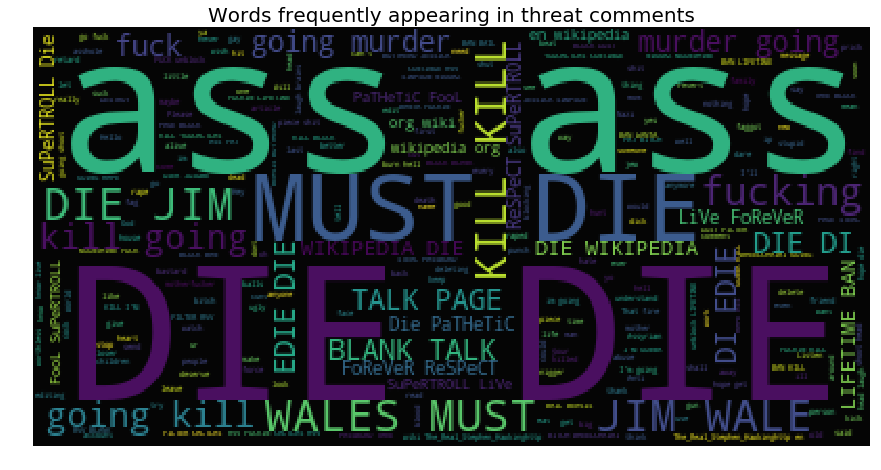

In [23]:
text = data[data["threat"]==1]['comment_text'].values
word_cloud(text,"Words frequently appearing in threat comments")

### CAUTION!!! -- you may find the following content *offensive*!

#### Visualize words frequently appearing in ***insulting*** comments

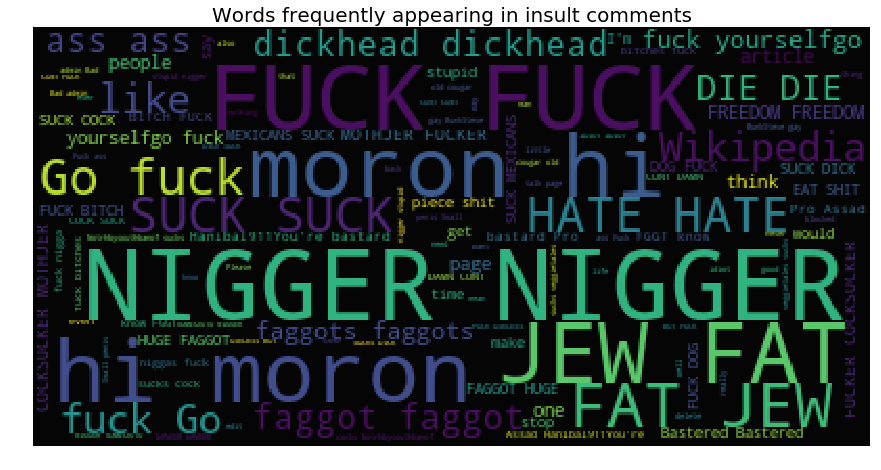

In [24]:
text = data[data["insult"]==1]['comment_text'].values
word_cloud(text,"Words frequently appearing in insult comments")

### CAUTION!!! -- you may find the following content *offensive*!

#### Visualize words frequently appearing in ***obscene*** comments

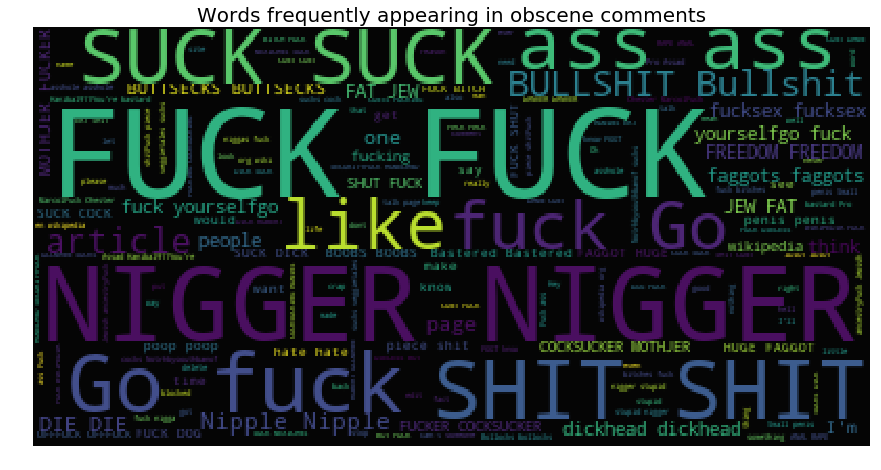

In [25]:
text = data[data["obscene"]==1]['comment_text'].values
word_cloud(text,"Words frequently appearing in obscene comments")

### CAUTION!!! -- you may find the following content *offensive*!

#### Visualize words frequently appearing in ***hateful*** comments

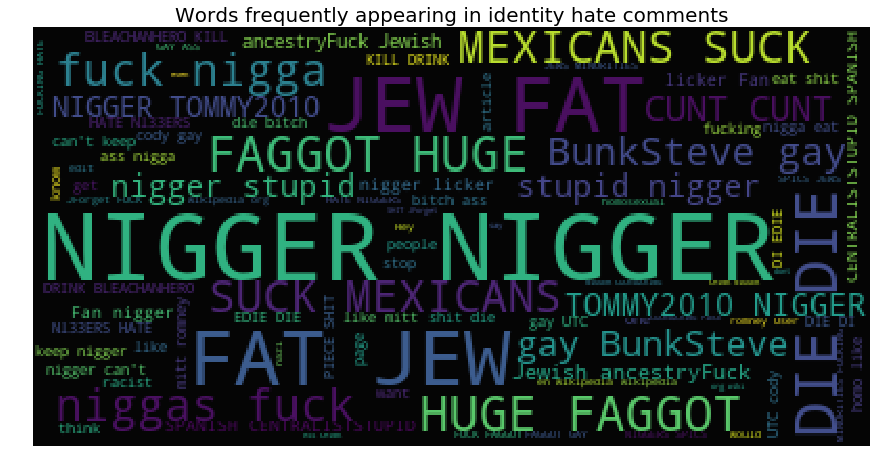

In [26]:
text = data[data["identity_hate"]==1]['comment_text'].values
word_cloud(text,"Words frequently appearing in identity hate comments")

#### Generate features that we may be able to use to create more accurate model(s)

##### Sentences count in each comment

In [27]:
#Sentences count in each comment
data['sentence_cnt'] = data["comment_text"].apply(lambda comment: len(re.findall("\n",str(comment)))+1)

##### Words count in each comment

In [28]:
#Words count in each comment
data['word_cnt'] = data["comment_text"].apply(lambda comment: len(str(comment).split()))

##### Unique words count in each comment

In [29]:
#Unique words count in each comment
data['unique_word_cnt'] = data["comment_text"].apply(lambda comment: len(set(str(comment).split())))

##### Stop words count in each comment

In [30]:
#Stop words count in each comment
data["stopwords_cnt"] = data["comment_text"].apply(lambda comment: len([word for word in str(comment).lower().split() if word in stop]))

##### Examine data

In [31]:
#Examine new features
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sentence_cnt,word_cnt,unique_word_cnt,stopwords_cnt
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,2,43,41,18
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,17,17,2
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,42,39,20
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,5,113,82,56
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,13,13,5


#### Examine elements that may introduce information ***leakage*** such as IP addresses, links, usernames, etc. in comments when creating models

##### IP Addresses

In [32]:
#IP addresses
data['ip'] = data["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))

#Count of IP addresses
data['count_ip'] = data["ip"].apply(lambda x: len(x))

##### Links

In [33]:
#Links
data['link'] = data["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))

#Count of links
data['count_links'] = data["link"].apply(lambda x: len(x))

##### Article IDs

In [34]:
#Article ids
data['article_id'] = data["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
data['article_id_flag'] = data.article_id.apply(lambda x: len(x))

##### Usernames

In [35]:
#Usernames
#Note: regex for Match anything with [[User: ---------- ]]
data['username'] = data["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))

#Count of username mentions
data['count_usernames'] = data["username"].apply(lambda x: len(x))

##### Examine data

In [36]:
data.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sentence_cnt,word_cnt,unique_word_cnt,stopwords_cnt,ip,count_ip,link,count_links,article_id,article_id_flag,username,count_usernames
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,2,43,41,18,[89.205.38.27],1,[],0,[],0,[],0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,17,17,2,[],0,[],0,[],0,[],0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,42,39,20,[],0,[],0,[],0,[],0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,5,113,82,56,[],0,[],0,[],0,[],0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,13,13,5,[],0,[],0,[],0,[],0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,3,13,12,4,[],0,[],0,[],0,[],0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1,8,8,4,[],0,[],0,[],0,[],0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1,20,20,12,[],0,[],0,[],0,[],0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1,83,70,42,[93.161.107.169],1,[],0,[],0,[],0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1,12,12,8,[],0,[],0,[],0,[],0


#### Examine distribution of targets -- base vs. comments _with_ links, IPs, usernames vs. comments _without_ links, IPs, usernames

##### Setup subset of data

In [37]:
comments_with_links = data[data['count_links'] > 0]
comments_with_no_links = data[data['count_links'] == 0]

comments_with_usernames = data[data['count_usernames'] > 0]
comments_with_no_usernames = data[data['count_usernames'] == 0]

comments_with_ips = data[data['count_ip'] > 0]
comments_with_no_ips = data[data['count_ip'] == 0]

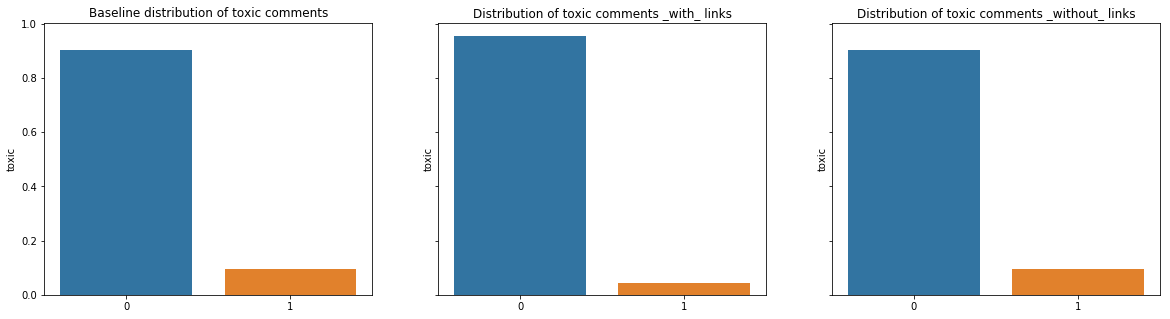

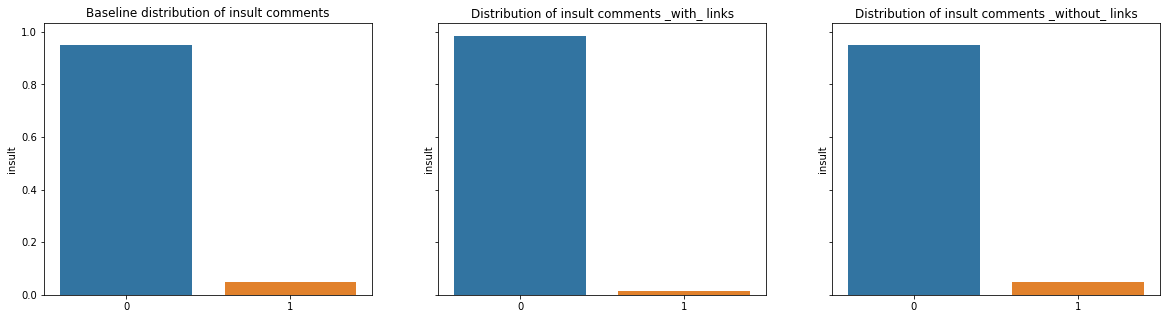

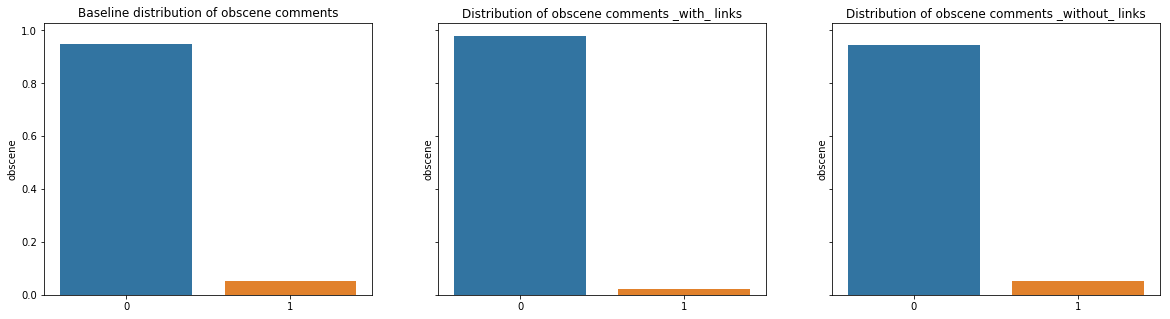

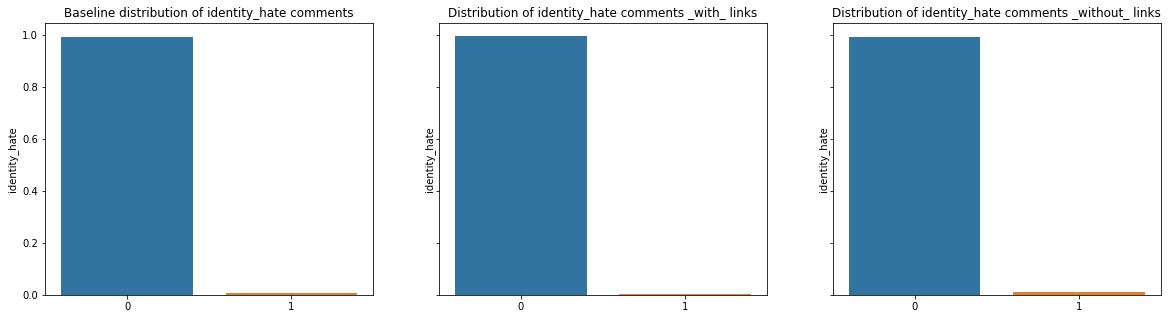

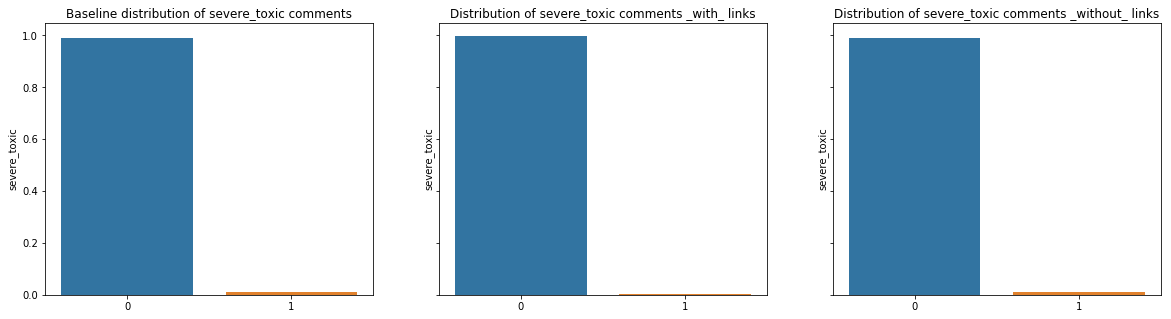

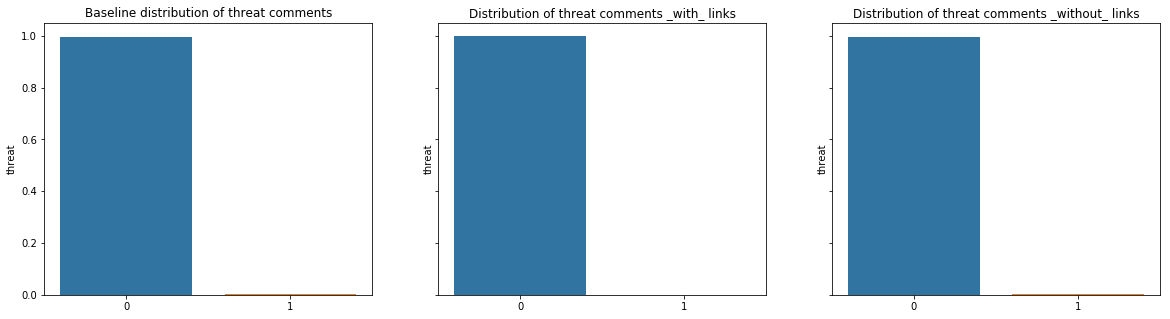

In [38]:
for target in targets:
    f, (ax1, ax2, ax3) = sns.mpl.pyplot.subplots(1, 3, figsize=(20,5), sharey="all")

    ax1.set_title("Baseline distribution of "+target+" comments")
    sns.barplot(x=data[target].value_counts().index, y=data[target].value_counts(normalize=True), ax=ax1)
    ax2.set_title("Distribution of "+target+" comments _with_ links")
    sns.barplot(x=comments_with_links[target].value_counts().index, y=comments_with_links[target].value_counts(normalize=True), ax=ax2)
    ax3.set_title("Distribution of "+target+" comments _without_ links")
    sns.barplot(x=comments_with_no_links[target].value_counts().index, y=comments_with_no_links[target].value_counts(normalize=True), ax=ax3);

##### ***Observation***: It appears that the presence of links, usernames, or IPs in comments doesn't have positive coorelation with respective targets.

#### Examine correlation between words count, unique words count and sentences count in comments and target classes

In [39]:
comments_with_less_than_10_words = data[data['word_cnt'] <= 10]
comments_with_more_than_10_words = data[data['word_cnt'] > 10]
comments_with_single_sentence = data[data['sentence_cnt'] == 1]
comments_with_more_than_one_sentence = data[data['sentence_cnt'] > 1]
comments_with_less_than_10_unique_words = data[data['unique_word_cnt'] <= 10]
comments_with_more_than_10_unique_words = data[data['unique_word_cnt'] > 10]

for target in targets:
    print("Percent of '{1}' comments with <= 10 words          : {0}%".\
          format(round(1-comments_with_less_than_10_words[target].value_counts(normalize=True)[0],2),target))
    print("Percent of '{1}' comments with > 10 words           : {0}%".\
          format(round(1-comments_with_more_than_10_words[target].value_counts(normalize=True)[0],2),target))

    print("Percent of '{1}' comments with 1 sentence           : {0}%".\
          format(round(1-comments_with_single_sentence[target].value_counts(normalize=True)[0],2),target))
    print("Percent of '{1}' comments with > 1 sentence         : {0}%".\
          format(round(1-comments_with_more_than_one_sentence[target].value_counts(normalize=True)[0],2),target))

    print("Percent of '{1}' comments with <= 10 unique words   : {0}%".\
          format(round(1-comments_with_less_than_10_unique_words[target].value_counts(normalize=True)[0],2),target))
    print("Percent of '{1}' comments with > 10 unique words    : {0}%".\
          format(round(1-comments_with_more_than_10_unique_words[target].value_counts(normalize=True)[0],2),target))
    print()

Percent of 'toxic' comments with <= 10 words          : 0.16%
Percent of 'toxic' comments with > 10 words           : 0.09%
Percent of 'toxic' comments with 1 sentence           : 0.11%
Percent of 'toxic' comments with > 1 sentence         : 0.09%
Percent of 'toxic' comments with <= 10 unique words   : 0.17%
Percent of 'toxic' comments with > 10 unique words    : 0.08%

Percent of 'insult' comments with <= 10 words          : 0.09%
Percent of 'insult' comments with > 10 words           : 0.04%
Percent of 'insult' comments with 1 sentence           : 0.06%
Percent of 'insult' comments with > 1 sentence         : 0.04%
Percent of 'insult' comments with <= 10 unique words   : 0.09%
Percent of 'insult' comments with > 10 unique words    : 0.04%

Percent of 'obscene' comments with <= 10 words          : 0.1%
Percent of 'obscene' comments with > 10 words           : 0.04%
Percent of 'obscene' comments with 1 sentence           : 0.06%
Percent of 'obscene' comments with > 1 sentence         :

#### Function to remove line breaks, possible "leaky" features, stop words, etc. from comment passed in as argument

In [40]:
def cleaner_text(comment):
    text = comment.lower()
    # remove linebreak
    text = re.sub("\\n"," ",text)
    # remove "leaky" feature IP
    text = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",text)
    # remove "leaky" feature usernames
    text = re.sub("\[\[.*\]","",text)
    text = nlp(text)
    # remove stop words
    text = [str(i.lemma_) for i in text if str(i.orth_) not in stop]
    text = ' '.join(text)
    return text

#### Transform / clean comments from both training and test datasets
##### NOTE: Depending on the size of the dataset this may take a while

In [216]:
# Transform / clean comments in train dataset
data["comment_text"] = data["comment_text"].apply(cleaner_text)

# Perform same transformation on test dataset
test["comment_text"] = test["comment_text"].apply(cleaner_text)

### Save transformed datasets
##### To avoid duplication these transformed datasets will be leveraged in modeling notebook

In [41]:
data.to_csv("data_clean.csv")
test.to_csv("test_clean.csv")

## Baseline Model

Use DummyClassifier to create baseline models using single feature -- ***comment_text***

In [ ]:
# Create a list of targets so it's easy to loop through them and create baseline models for each
targets = ['toxic', 'severe_toxic', 'obscene', 'insult', 'identity_hate','threat']
all_text = data['comment_text']

# Create word vectorizer 
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)

# Create character vectorizer 
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)

# Fit vectorizers on training dataset
word_vectorizer.fit(all_text)
char_vectorizer.fit(all_text)

# Transform training dataset
word_features = word_vectorizer.transform(all_text)
char_features = char_vectorizer.transform(all_text)
features = hstack([char_features, word_features])

In [ ]:
# Loop through six (6) targets and create baseline model for each target using train_test_split cross-validation
for target in targets:

    y = data[target]
        
    # Split data in training and test sets
    X_train,X_test,y_train,y_test = train_test_split(features,y,random_state=42,stratify=y)

    # Create dummyclassifier with "stratified" strategy which generates predictions by respecting the training set's 
    # class distribution
    dumb_model = DummyClassifier(strategy='stratified')
    dumb_model.fit(X_train, y_train)
    y_dumb_predictions = dumb_model.predict(X_test)

    # Print roc_auc_score and accuracy score
    print("Baseline roc_auc_score for {1} comments  : {0}".format(metrics.roc_auc_score(y_test, y_dumb_predictions),target))
    print("Baseline accuracy_score for {1} comments : {0}".format(metrics.accuracy_score(y_test, y_dumb_predictions),target))
    print()

Baseline roc_auc_score for toxic comments  : 0.4986673069144205
Baseline accuracy_score for toxic comments : 0.8279648058556639

Baseline roc_auc_score for severe_toxic comments  : 0.4947207170709475
Baseline accuracy_score for severe_toxic comments : 0.9795452836337202



## Inferences

* The dataset contains highly unbalanced classes
 *  It will be beneficial to deploy oversampling-undersampling techniques to create models that will generalize well on unseen data
* Since a given comment may be labeled (true) for more than one target/class, six (6) models will need to be created and persisted

## Next Steps

* Feature engineering
* Model(s) selection
* Model(s) creation
* Model(s) evaluation